<a href="https://colab.research.google.com/github/magichan-lab/MINGW-packages/blob/master/citation_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 論文の被引用数予測

https://prob.space/competitions/citation_prediction

## ■初期設定

In [ ]:
!pip install optuna

In [87]:
from google.colab import files, drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
import optuna.integration.lightgbm as _lgb
import nltk
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import regex
import json
import os

In [ ]:
tqdm.pandas()

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

In [ ]:
# 設定
NUM_FOLDS = 4
SEED = 1000
METRICS = 'rmse'
TEST_SIZE = 0.25
OUTPUT_FILE = 'submit8.csv'

In [ ]:
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## ■データ読み込み

In [ ]:
DATA_PATH = '/gdrive/MyDrive/ProbSpace/citation_prediction/'

In [ ]:
train_file = os.path.join(DATA_PATH, 'train_data.json')
test_file = os.path.join(DATA_PATH, 'test_data.json')

num_of_lines = sum(1 for _ in open(train_file, 'r'))
with open(train_file, 'r') as f:
    tmp = []
    for line in tqdm(f, total=num_of_lines):
        tmp.append(json.loads(line))
    train_df = pd.DataFrame(tmp).set_index('id', drop=True)

num_of_lines = sum(1 for _ in open(test_file, 'r'))
with open(test_file, 'r') as f:
    tmp = []
    for line in tqdm(f, total=num_of_lines):
        tmp.append(json.loads(line))
    test_df = pd.DataFrame(tmp).set_index('id', drop=True)

# 以下の方がシンプルで早いかも・・。でもプログレスバー出た方が良いので上を使う
# train_df = pd.read_json(train_file, lines=True).set_index('id', drop=True)
# test_df = pd.read_json(test_file, lines=True).set_index('id', drop=True)

all_df = pd.concat([train_df.assign(train=True), test_df.assign(cites=0, train=False)])

all_df.head()

100%|██████████| 59084/59084 [00:03<00:00, 18277.57it/s]


,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,doi_cites,cites,train
id,,,,,,,,,,,,,,,,
hep-ph/9902295,Michael Kraemer,Mark E. Hayes (University College London) and ...,Heavy-Flavour Production at HERA,"LaTeX, 21 pages, 13 Postscript figures. Summar...","J.Phys.G25:1477-1493,1999",10.1088/0954-3899/25/7/332,"CERN-TH/99-30, UCL/HEP 99-03",hep-ph hep-ex,None,We review the theoretical and experimental s...,"[{'version': 'v1', 'created': 'Wed, 10 Feb 199...",2008-11-26,"[[Hayes, Mark E., , University College London]...",1,NaN,True
1403.7138,Aigen Li,"Qi Li, S.L. Liang, Aigen Li (University of Mis...",Spectropolarimetric Constraints on the Nature ...,"5 pages, 2 figures; accepted for publication i...",None,10.1093/mnrasl/slu021,None,astro-ph.GA,http://arxiv.org/licenses/nonexclusive-distrib...,While it is well recognized that interstella...,"[{'version': 'v1', 'created': 'Thu, 27 Mar 201...",2015-06-19,"[[Li, Qi, , University of Missouri], [Liang, S...",8,7.0,True
1405.5857,Michael Mortonson,"Michael J. Mortonson, Uro\v{s} Seljak",A joint analysis of Planck and BICEP2 B modes ...,"13 pages, 4 figures; submitted to JCAP; refere...",JCAP10(2014)035,10.1088/1475-7516/2014/10/035,None,astro-ph.CO gr-qc hep-ph hep-th,http://arxiv.org/licenses/nonexclusive-distrib...,We analyze BICEP2 and Planck data using a mo...,"[{'version': 'v1', 'created': 'Thu, 22 May 201...",2014-10-17,"[[Mortonson, Michael J., ], [Seljak, Uroš, ]]",122,188.0,True
1807.01034,Evangelos Thomas Karamatskos,"Evangelos T. Karamatskos, Sebastian Raabe, Ter...",Molecular movie of ultrafast coherent rotation...,9 Figures,"Nat Commun 10, 3364 (2019)",10.1038/s41467-019-11122-y,None,physics.chem-ph physics.atom-ph quant-ph,http://arxiv.org/licenses/nonexclusive-distrib...,Recording molecular movies on ultrafast time...,"[{'version': 'v1', 'created': 'Tue, 3 Jul 2018...",2020-05-19,"[[Karamatskos, Evangelos T., ], [Raabe, Sebast...",6,8.0,True
1905.05921,Juanjuan Gu,Juanjuan Gu and Yun Jing,A Modified Mixed Domain Method for Modeling Ac...,None,None,10.1121/10.0001454,None,physics.med-ph physics.comp-ph,http://arxiv.org/licenses/nonexclusive-distrib...,"In this paper, phase correction and amplitud...","[{'version': 'v1', 'created': 'Wed, 15 May 201...",2020-07-15,"[[Gu, Juanjuan, ], [Jing, Yun, ]]",0,NaN,True


In [ ]:
all_df = all_df.astype({
    'doi_cites': 'int',
    'cites': 'float',
    })
all_df.dtypes

submitter          object
authors            object
title              object
comments           object
journal-ref        object
doi                object
report-no          object
categories         object
license            object
abstract           object
versions           object
update_date        object
authors_parsed     object
doi_cites           int64
cites             float64
train                bool
dtype: object

## ■目的変数

In [ ]:
all_df[all_df.train].cites.describe()

count    15117.000000
mean        30.427664
std        122.773141
min          1.000000
25%          4.000000
50%         11.000000
75%         28.000000
max       8723.000000
Name: cites, dtype: float64

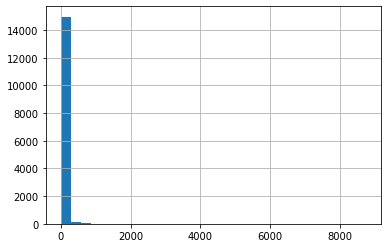

In [ ]:
all_df[all_df.train].cites.hist(bins=30)

In [ ]:
all_df['log_cites'] = all_df['cites'].apply(np.log1p)

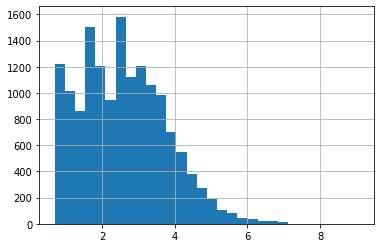

In [ ]:
all_df[all_df.train].log_cites.hist(bins=30)

## ■説明変数

### submitter

- submitter_count
- submitter_eptcs

In [ ]:
# Submitした回数を追加
all_df['submitter_eptcs'] = (all_df['submitter'] == 'EPTCS')
tmp = all_df['submitter'].value_counts()
tmp['EPTCS'] = 0
all_df['submitter_count'] = all_df['submitter'].map(tmp)
all_df['submitter_count'] = all_df['submitter_count'].fillna(0).astype(int)

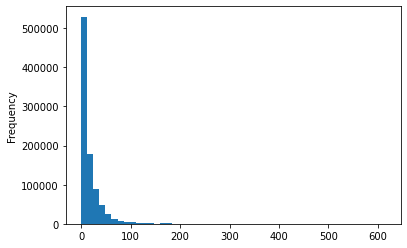

In [ ]:
all_df['submitter_count'].plot.hist(bins=50)

###authors

- 未使用(authors_parsed の方を使用する)

###title

- 未使用

In [ ]:
words = []
def f(title):
    morph = nltk.word_tokenize(title)
    words.extend(w.lower() for w,v in nltk.pos_tag(morph) if v in ['NN', 'NNS', 'NNP'])
#all_df['title'].progress_apply(f)
#print(words)

In [ ]:
pd.Series(words).value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


Series([], dtype: int64)

###comments

- 未使用

###journal-ref

https://www.oecd-nea.org/dbdata/dictionaries/journal.html

http://www.math.nagoya-u.ac.jp/~hamanaka/ronbun.html


In [ ]:
# Published in some Journal
all_df['in_journal'] = True
all_df.loc[all_df['journal-ref'].isna(), 'in_journal'] = False

In [ ]:
# とりあえず括弧を削除
#def f(journal):
#    result = None
#    if journal is not None:
#        ptn = regex.compile(r'\(((?>[^\(\)]+|(?R))*)\)')
#        result = regex.sub(ptn, '', journal)
#    return result

#all_df['journal-ref'] = all_df['journal-ref'].progress_apply(f)

In [ ]:
all_df['journal-ref']

id
hep-ph/9902295               J.Phys.G25:1477-1493,1999
1403.7138                                         None
1405.5857                              JCAP10(2014)035
1807.01034                  Nat Commun 10, 3364 (2019)
1905.05921                                        None
                                   ...                
1210.4112            Phys. Lett. B. 718 (2013) 902-907
1701.03465                                        None
1709.10428                                        None
gr-qc/9803020       Class.Quant.Grav.15:1637-1651,1998
cond-mat/0512492        Phys. Rev. E 73, 046104 (2006)
Name: journal-ref, Length: 910608, dtype: object

In [ ]:
"""
print(x.count())
x = x[~x.str.startswith('J.Phys.J')] #
OK x = x[~x.str.startswith('Eur.Phys.J')] #11463
x = x[~x.str.startswith('Class.Quant')] #7017
x = x[~x.str.startswith('NatCommun')] #63
OK x = x[~x.str.startswith('Astrophys')] #27272
x = x[~x.str.startswith('J.Quant.Spectros')] #230
x = x[~x.str.startswith('StudiaMath')] #81
OK x = x[~x.str.startswith('Phys.Lett')] #23620
OK x = x[~x.str.startswith('Phys.Rev')] #189195
OK x = x[~x.str.startswith('PhysicalReview')] #10077
x = x[~x.str.startswith('Invent.Math')] #145
OK x = x[~x.str.startswith('J.Phys')] #19871
x = x[~ x.str.startswith('Gen.Rel.Grav')] #1490
x = x[~x.str.startswith('Chaos')] # 813
x = x[~x.str.startswith('AIPConf.Proc')] #3533
x = x[~x.str.startswith('JCAP')] #4860
#x = x[~x.str.startswith('JHEP')] #17765
x = x[~x.str.startswith('Int.J.')] #9160
x = x[~x.str.startswith('InternationalJournal')] #3615
x = x[~x.str.startswith('APJ')] #16
x = x[~x.str.startswith('Phys.Plasmas')] #393
x = x[~x.str.startswith('Mod.Phys.Lett')] #4577
x = x[~x.str.startswith('Lect.NotesPhys')] # 222
x = x[~x.str.contains('A&A')] #9234
x = x[~x.str.contains('ApJ')] #3803
x = x[~x.str.contains('MNRAS')] #3081
x = x[~x.str.contains('AJ')] # 458
x = x[x.str.contains('NewJ.Phys')] # 458
"""


"\nprint(x.count())\nx = x[~x.str.startswith('J.Phys.J')] #\nOK x = x[~x.str.startswith('Eur.Phys.J')] #11463\nx = x[~x.str.startswith('Class.Quant')] #7017\nOK x = x[~x.str.startswith('Phys.Rev')] #189195\nx = x[~x.str.startswith('NatCommun')] #63\nOK x = x[~x.str.startswith('Astrophys')] #27272\nx = x[~x.str.startswith('J.Quant.Spectros')] #230\nx = x[~x.str.startswith('StudiaMath')] #81\nOK x = x[~x.str.startswith('Phys.Lett')] #23620\nOK x = x[~x.str.startswith('PhysicalReview')] #10077\nx = x[~x.str.startswith('Invent.Math')] #145\nx = x[~x.str.startswith('J.Phys')] #19871\nx = x[~ x.str.startswith('Gen.Rel.Grav')] #1490\nx = x[~x.str.startswith('Chaos')] # 813\nx = x[~x.str.startswith('AIPConf.Proc')] #3533\nx = x[~x.str.startswith('JCAP')] #4860\nx = x[~x.str.startswith('JHEP')] #17765\nx = x[~x.str.startswith('Int.J.')] #9160\nx = x[~x.str.startswith('InternationalJournal')] #3615\nx = x[~x.str.startswith('APJ')] #16\nx = x[~x.str.startswith('Phys.Plasmas')] #393\nx = x[~x.str.

In [ ]:
### The European Physical Journal(EPJ)
tmp = all_df['journal-ref'].dropna()# .str.replace(' ', '')

epj = tmp.str.upper().str.contains('EPJ[\s\d/,\.]', regex=True) | \
      tmp.str.upper().str.contains('EPJ-?A[\s\d/,\.]', regex=True) | \
      tmp.str.upper().str.contains('EPJ-?B[\s\d/,\.]', regex=True) | \
      tmp.str.upper().str.contains('EPJ-?C[\s\d/,\.]', regex=True) | \
      tmp.str.upper().str.contains('EPJ-?D[\s\d/,\.]', regex=True) | \
      tmp.str.upper().str.contains('EPJ-?ST[\s\d/,\.]', regex=True) | \
      tmp.str.upper().str.contains('EPJ-?SPECIAL[\s\d/,\.]', regex=True) | \
      tmp.str.upper().str.contains('EPJ-?N[\s\d/,\.]', regex=True) | \
      tmp.str.upper().str.contains('EUR[\.\s]*PHYS[\.\s]*J', regex=True) | \
      tmp.str.upper().str.contains('EUROP[\.\s]*PHYS[\.\s]*J', regex=True) | \
      tmp.str.upper().str.contains('EUROPEAN[\.\s]*PHYSICAL[\.\s]*J', regex=True) 

all_df['journal_epj'] = epj
all_df['journal_epj'] = all_df['journal_epj'].fillna(False)
print(epj.sum())


In [ ]:
### Journal of the Physical Society of Japans(JPJ)
tmp = all_df['journal-ref'].dropna().str.replace(' ', '').str.upper()

jpj = tmp.str.contains('JOURNAL\s*OF\s*THE\s*PHYSICAL\s*SOCIETY\s*OF\s*JAPAN', regex=True)

all_df['journal_jpj'] = jpj
all_df['journal_jpj'] = all_df['journal_jpj'].fillna(False)
print(jpj.sum())

163


In [ ]:
### Physical Reviews(PR)
tmp = all_df['journal-ref'].dropna().str.replace(' ', '').str.upper()

pr = tmp.str.contains('PHYS[\.\s]*REV[\.\s]') | \
     tmp.str.contains('PHYSICAL[\.\s]*REVIEW[\.\,\s/\d]') | \
     tmp.str.contains('PR/A[\.\s]') | \
     tmp.str.contains('PR/B[\.\s]') | \
     tmp.str.contains('PR/C[\.\s]') | \
     tmp.str.contains('PR/D[\.\s]') 

all_df['journal_pr'] = pr
all_df['journal_pr'] = all_df['journal_pr'].fillna(False)
print(pr.sum())

188977


In [ ]:
### Applied Physics Letters(APL)
tmp = all_df['journal-ref'].dropna().str.replace(' ', '').str.upper()

apl = tmp.str.contains('PHYS[\.\s]*LETT[\.\s]') | \
      tmp.str.contains('PHYSICS[\.\s]*LETTERS[\.\,\s/\d]')

all_df['journal_apl'] = apl    
all_df['journal_apl'] = all_df['journal_apl'].fillna(False)
print(apl.sum())

35768


In [ ]:
### Astrophysical Journals(AJ)
tmp = all_df['journal-ref'].dropna().str.replace(' ', '').str.upper()

aj = tmp.str.contains('ASTROPHYS[\.\s]') | \
     tmp.str.contains('ASTROPHYSICAL[\.\s]*JOURNALS?[\.\,\s\d]')

all_df['journal_aj'] = aj
all_df['journal_aj'] = all_df['journal_aj'].fillna(False)

print(aj.sum())
#print(tmp[~aj & tmp.str.contains('ASTROPHYSICAL')])

25165


In [ ]:
### Journal of Physical Chemistrysby Am. Chem. Society(PCJ)
tmp = all_df['journal-ref'].dropna().str.replace(' ', '').str.upper()

pcj = tmp.str.contains('J[\.\s]*PHYS[\.\,\s\d]') | \
      tmp.str.contains('JOURNAL[\.\s]*OF[\.\s]*PHYSICS') | \
      tmp.str.contains('JOURNAL[\.\s]*OF[\.\s]*PHYSICAL')

all_df['journal_pcj'] = pcj
all_df['journal_pcj'] = all_df['journal_pcj'].fillna(False)

print(pcj.sum())
#tmp[~epj & ~jpj & ~pr & ~apl & ~aj & ~pcj & tmp.str.contains("JOURNAL") & tmp.str.contains("PHY")]


29604


In [ ]:
### The Journal of High Energy Physics (JHEP) 
tmp = all_df['journal-ref'].dropna().str.replace(' ', '').str.upper()

jhep = tmp.str.startswith('JHEP')

all_df['journal_jhep'] = jhep
all_df['journal_j'] = all_df['journal_pcj'].fillna(False)

print(jhep.sum())

17765


In [ ]:
tmp = all_df['journal-ref'].dropna().str.replace(' ', '').str.upper()
tmp[~epj & ~jpj & ~pr & ~apl & ~aj & tmp.str.contains("J.PHYS")]

id
hep-ph/9902295                  J.PHYS.G25:1477-1493,1999
1109.1968                 AM.J.PHYS.80(2),2012,PP.164-169
0709.2480          J.PHYS.:CONDENS.MATTER,20,075227(2008)
1804.00265          J.PHYS.:CONDENS.MATTER30,385602(2018)
1503.00499                      EUR.J.PHYS.36(2015)035022
                                    ...                  
1312.4235          J.PHYS.CHEM.B117(48),14928-14939(2013)
1802.01431                 J.PHYS.COND.MAT.3010LT01(2018)
hep-ph/0602003            J.PHYS.CONF.SER.39(2006)435-437
nucl-th/0311022                 J.PHYS.G29:2569-2596,2003
1207.5671                CENT.EUR.J.PHYS.10(3)2012540-551
Name: journal-ref, Length: 25989, dtype: object

###doi

- 未使用

###report-no

- 未使用

###categories

- TOP50 をOneHot化

In [ ]:
N = 50

# all_df['categories'].nunique()
# all_df['categories'].unique()
categories = all_df['categories'].str.split(expand=True).stack()
# categories.nunique() # 176
categories.unique()

array(['hep-ph', 'hep-ex', 'astro-ph.GA', 'astro-ph.CO', 'gr-qc',
       'hep-th', 'physics.chem-ph', 'physics.atom-ph', 'quant-ph',
       'physics.med-ph', 'physics.comp-ph', 'math.ST', 'stat.ME',
       'stat.TH', 'astro-ph', 'physics.optics', 'physics.ao-ph',
       'astro-ph.SR', 'cs.LG', 'cond-mat.stat-mech', 'cond-mat.dis-nn',
       'cond-mat.mes-hall', 'nlin.PS', 'cond-mat.supr-con',
       'physics.gen-ph', 'cs.SE', 'cond-mat.mtrl-sci', 'cs.CV',
       'physics.plasm-ph', 'astro-ph.HE', 'physics.space-ph',
       'cond-mat.other', 'astro-ph.EP', 'nucl-th', 'nlin.CD',
       'physics.data-an', 'nucl-ex', 'comp-gas', 'nlin.CG', 'math.AG',
       'math.CV', 'math.GT', 'cond-mat.str-el', 'cs.FL', 'cs.CC',
       'physics.app-ph', 'physics.class-ph', 'eess.SP', 'stat.AP',
       'math.PR', 'hep-lat', 'cond-mat.quant-gas', 'math.OC', 'stat.ML',
       'cond-mat.soft', 'physics.flu-dyn', 'math.RT', 'math.NT',
       'math.FA', 'math-ph', 'math.MP', 'cs.SI', 'cs.DL',
       'physics.

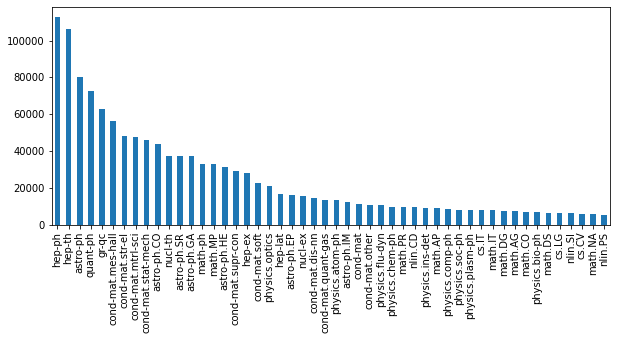

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
categories.value_counts()[:N].plot.bar(ax=ax)

In [ ]:
for idx in tqdm(categories.value_counts()[:N].index):
    all_df[f'cat_{idx}'] = (all_df['categories'].str.split(expand=True) == idx).any(axis=1)

100%|██████████| 50/50 [04:20<00:00,  5.21s/it]


In [ ]:
all_df['num_of_categories'] = all_df['categories'].str.split().apply(len)

###license

- カテゴリ変数化

In [ ]:
all_df['license'] = all_df.license.map({
    'http://arxiv.org/licenses/nonexclusive-distrib/1.0/' : 'non-exclusive',
    'http://creativecommons.org/licenses/by/4.0/' : 'cc_by',
    'http://creativecommons.org/licenses/by-sa/4.0/' : 'cc_by-sa',
    'http://creativecommons.org/licenses/by-nd/4.0/' : 'cc_by-nd',
    'http://creativecommons.org/licenses/by-nc/4.0/' : 'cc_by-nc',
    'http://creativecommons.org/licenses/by-nc-sa/4.0/' : 'cc_by-nc-sa',
    'http://creativecommons.org/licenses/by-nc-nd/4.0/' : 'cc_by-nc-nd',
    'http://creativecommons.org/publicdomain/zero/1.0/' : 'cc0',
    #'http://creativecommons.org/licenses/by/3.0/' : 'cc_by3.0',
    'http://creativecommons.org/licenses/by/3.0/' : 'cc_by',
    #'http://creativecommons.org/licenses/by-nc-sa/3.0/' : 'cc_by-nc-sa3.0',
    'http://creativecommons.org/licenses/by-nc-sa/3.0/' : 'cc_by-nc-sa',
    'http://creativecommons.org/licenses/publicdomain/' : 'cc_public-domain'
}).astype('category')

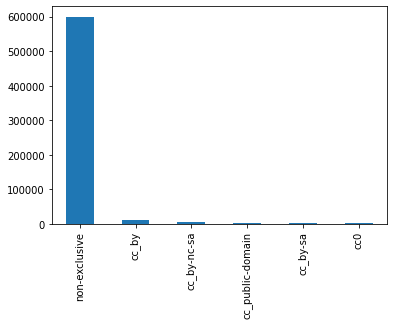

In [ ]:
all_df['license'].value_counts().plot.bar()

###abstract

In [ ]:
all_df['abstract']

id
hep-ph/9902295        We review the theoretical and experimental s...
1403.7138             While it is well recognized that interstella...
1405.5857             We analyze BICEP2 and Planck data using a mo...
1807.01034            Recording molecular movies on ultrafast time...
1905.05921            In this paper, phase correction and amplitud...
                                          ...                        
1210.4112             The asymmetry in the production cross-sectio...
1701.03465            Ultra-faint dwarf galaxies (UFDs) are the fa...
1709.10428            We consider a class of one-dimensional quant...
gr-qc/9803020         We test the chronology protection conjecture...
cond-mat/0512492      We present the analysis of the first passage...
Name: abstract, Length: 910608, dtype: object

###versions

In [ ]:
all_df['num_of_versions'] = all_df['versions'].progress_apply(lambda d: len(d))
all_df['first_edition_publication_date'] = all_df['versions'].progress_apply(lambda d: pd.to_datetime(d[0]["created"]))
all_df['first_edition_publication_year'] = all_df['first_edition_publication_date'].dt.year
all_df['last_edition_publication_date'] = all_df['versions'].progress_apply(lambda d: pd.to_datetime(d[-1]["created"]))
all_df['last_edition_publication_year'] = all_df['last_edition_publication_date'].dt.year
all_df['renewal_period'] = (all_df['last_edition_publication_date'] - all_df['first_edition_publication_date']).dt.days

100%|██████████| 910608/910608 [05:24<00:00, 2802.37it/s]


###update_date

In [ ]:
all_df['update_date'] = pd.to_datetime(all_df['update_date'])
all_df['update_date']

id
hep-ph/9902295     2008-11-26
1403.7138          2015-06-19
1405.5857          2014-10-17
1807.01034         2020-05-19
1905.05921         2020-07-15
                      ...    
1210.4112          2012-12-20
1701.03465         2017-02-08
1709.10428         2018-02-14
gr-qc/9803020      2011-07-19
cond-mat/0512492   2020-03-16
Name: update_date, Length: 910608, dtype: datetime64[ns]

###authors_parsed

In [ ]:
N = 50
def conv_auth(auths):
    tmp = []
    for auth in auths:
        if len(auth) < 2 or auth[2] == '':
            tmp.append(' '.join(auth[:2]))
        else:
            tmp.append(' '.join(auth[:3]))
    return tmp

all_df['authors_parsed'] = all_df.loc[:, 'authors_parsed'].progress_apply(conv_auth)

100%|██████████| 910608/910608 [00:03<00:00, 229803.80it/s]


In [ ]:
tmp = []
for auths in tqdm(all_df['authors_parsed']):
    tmp.extend(auths)
authors = pd.Series(tmp)

100%|██████████| 910608/910608 [00:00<00:00, 1322382.78it/s]


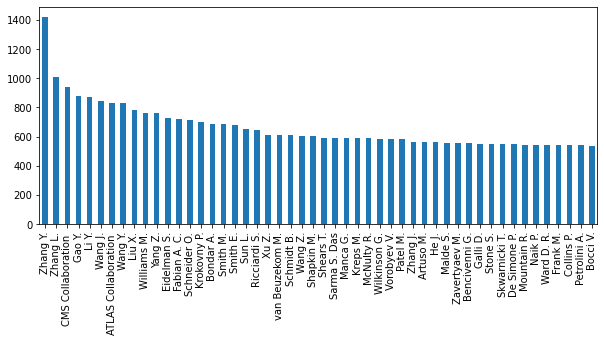

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
authors.value_counts()[:N].plot.bar(ax=ax)

In [ ]:
for idx in tqdm(authors.value_counts()[:N].index):
    all_df[f'auth_{idx}'] = all_df['authors_parsed'].apply(lambda d: idx in d)
print(all_df)

100%|██████████| 50/50 [00:20<00:00,  2.46it/s]


                                     submitter  ... auth_Bocci V.
id                                              ...              
hep-ph/9902295                 Michael Kraemer  ...         False
1403.7138                             Aigen Li  ...         False
1405.5857                    Michael Mortonson  ...         False
1807.01034        Evangelos Thomas Karamatskos  ...         False
1905.05921                         Juanjuan Gu  ...         False
...                                        ...  ...           ...
1210.4112                        Hamish Gordon  ...          True
1701.03465                       In Sung  Jang  ...         False
1709.10428                       Vincent Beaud  ...         False
gr-qc/9803020                      Kengo Maeda  ...         False
cond-mat/0512492             Bartlomiej Dybiec  ...         False

[910608 rows x 132 columns]


In [ ]:
all_df['num_of_authors'] = all_df['authors_parsed'].apply(len)

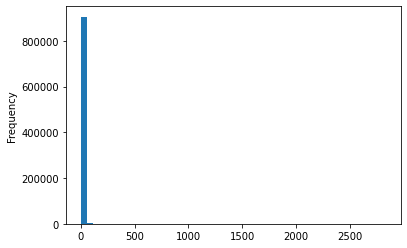

In [ ]:
all_df['num_of_authors'].plot.hist(bins=50)

### doi_cites

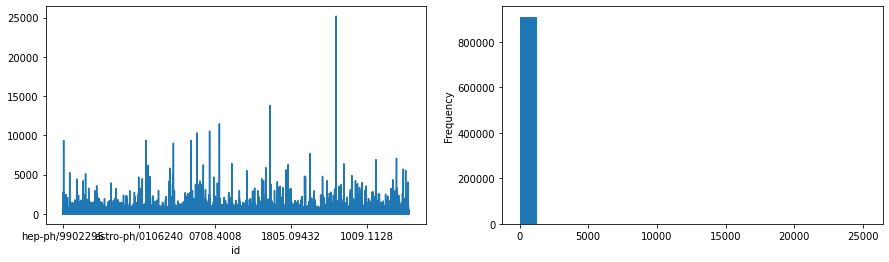

In [ ]:
all_df['doi_cites']
fig, axs = plt.subplots(1, 2, figsize=(15,4))
all_df['doi_cites'].plot(ax=axs[0])
all_df.doi_cites.plot.hist(bins=20, ax=axs[1])

In [ ]:
all_df['log_doi_cites'] = all_df['doi_cites'].apply(np.log1p)

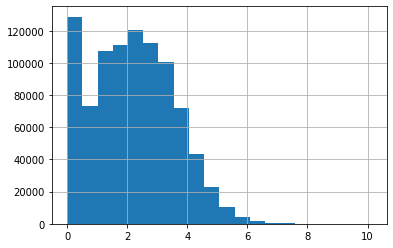

In [ ]:
all_df.log_doi_cites.hist(bins=20)

## ■TRAINING

In [ ]:
all_df.columns.values

array(['submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed', 'doi_cites', 'cites', 'train',
       'log_cites', 'submitter_eptcs', 'submitter_count', 'in_journal',
       'journal_epj', 'journal_jpj', 'journal_pr', 'journal_apl',
       'journal_aj', 'cat_hep-ph', 'cat_hep-th', 'cat_astro-ph',
       'cat_quant-ph', 'cat_gr-qc', 'cat_cond-mat.mes-hall',
       'cat_cond-mat.str-el', 'cat_cond-mat.mtrl-sci',
       'cat_cond-mat.stat-mech', 'cat_astro-ph.CO', 'cat_nucl-th',
       'cat_astro-ph.SR', 'cat_astro-ph.GA', 'cat_math-ph', 'cat_math.MP',
       'cat_astro-ph.HE', 'cat_cond-mat.supr-con', 'cat_hep-ex',
       'cat_cond-mat.soft', 'cat_physics.optics', 'cat_hep-lat',
       'cat_astro-ph.EP', 'cat_nucl-ex', 'cat_cond-mat.dis-nn',
       'cat_cond-mat.quant-gas', 'cat_physics.atom-ph', 'cat_astro-ph.IM',
       'cat_cond-mat', 'cat_cond-mat.other', 'cat_physic

In [ ]:
# 使用する説明変数
feature_params = [
                  ## submitter
                  'submitter_count',
                  'submitter_eptcs',
                  ## authors
                  ## title
                  ## comments
                  ## jurnal-ref
                  'in_journal',
                  'journal_epj',
                  'journal_jpj',                  
                  'journal_pr',
                  'journal_apl',
                  'journal_aj',
                  'journal_pcj',
                  ## doi
                  ## report-no
                  ## categories
                  'cat_hep-ph',
                  'cat_hep-th',
                  'cat_astro-ph',
                  'cat_quant-ph',
                  'cat_gr-qc',
                  'cat_cond-mat.mes-hall',
                  'cat_cond-mat.str-el',
                  'cat_cond-mat.mtrl-sci',
                  'cat_cond-mat.stat-mech',
                  'cat_astro-ph.CO',
                  'cat_nucl-th',
                  'cat_astro-ph.SR',
                  'cat_astro-ph.GA',
                  'cat_math-ph',
                  'cat_math.MP',
                  'cat_astro-ph.HE',
                  'cat_cond-mat.supr-con',
                  'cat_hep-ex',
                  'cat_cond-mat.soft',
                  'cat_physics.optics',
                  'cat_hep-lat',
                  'cat_astro-ph.EP',
                  'cat_nucl-ex',
                  'cat_cond-mat.dis-nn',
                  'cat_cond-mat.quant-gas',
                  'cat_physics.atom-ph',
                  'cat_astro-ph.IM',
                  'cat_cond-mat',
                  'cat_cond-mat.other',
                  'cat_physics.flu-dyn',
                  'cat_physics.chem-ph',
                  'cat_math.PR',
                  'cat_nlin.CD',
                  'cat_physics.ins-det',
                  'cat_math.AP',
                  'cat_physics.comp-ph',
                  'cat_physics.soc-ph',
                  'cat_physics.plasm-ph',
                  'cat_cs.IT',
                  'cat_math.IT',
                  'cat_math.DG',
                  'cat_math.AG',
                  'cat_math.CO',
                  'cat_physics.bio-ph',
                  'cat_math.DS',
                  'cat_cs.LG',
                  'cat_nlin.SI',
                  'cat_cs.CV',
                  'cat_math.NA',
                  'cat_nlin.PS',                  
                  'num_of_categories',
                  ## license
                  'license',
                  ## abstract
                  ## versions
                  'num_of_versions',
                  'first_edition_publication_year',
                  'last_edition_publication_year',                 
                  'renewal_period',
                  ## update_date
                  ## authors_parsed
                  'auth_Zhang Y.',
                  'auth_Zhang L.',
                  'auth_CMS Collaboration ',
                  'auth_Gao Y.',
                  'auth_Li Y.',
                  'auth_Wang J.',
                  'auth_ATLAS Collaboration ',
                  'auth_Wang Y.',
                  'auth_Liu X.',
                  'auth_Williams M.',
                  'auth_Yang Z.',
                  'auth_Eidelman S.',
                  'auth_Fabian A. C.',
                  'auth_Schneider O.',
                  'auth_Krokovny P.',
                  'auth_Bondar A.',
                  'auth_Smith M.',
                  'auth_Smith E.',
                  'auth_Sun L.',
                  'auth_Ricciardi S.',
                  'auth_Xu Z.',
                  #'auth_van Beuzekom M.', 'auth_Schmidt B.', 'auth_Wang Z.',
                  #'auth_Shapkin M.', 'auth_Shears T.', 'auth_Sarma S. Das',
                  #'auth_Kreps M.', 'auth_Manca G.', 'auth_McNulty R.',
                  #'auth_Wilkinson G.', 'auth_Vorobyev V.', 'auth_Patel M.',
                  #'auth_Zhang J.', 'auth_Artuso M.', 'auth_He J.', 'auth_Malde S.',
                  #'auth_Zavertyaev M.', 'auth_Bencivenni G.', 'auth_Galli D.',
                  #'auth_Stone S.', 'auth_Skwarnicki T.', 'auth_De Simone P.',
                  #'auth_Mountain R.', 'auth_Naik P.', 'auth_Ward D. R.',
                  #'auth_Frank M.', 'auth_Collins P.', 'auth_Petrolini A.',
                  #'auth_Bocci V.',
                  'num_of_authors',
                  ## doi_cites
                  'log_doi_cites',
]


In [ ]:
all_df.loc[:, feature_params].describe()

,submitter_count,num_of_categories,num_of_versions,first_edition_publication_year,last_edition_publication_year,renewal_period,num_of_authors,log_doi_cites
count,910608.000000,910608.000000,910608.000000,910608.000000,910608.000000,910608.000000,910608.000000,910608.000000
mean,18.212970,1.606107,1.599747,2010.273573,2010.522048,89.526855,5.155877,2.154042
std,32.519361,0.881442,0.891613,6.765578,6.822862,232.945363,25.933058,1.410395
min,0.000000,1.000000,1.000000,1986.000000,1986.000000,-292.000000,1.000000,0.000000
25%,4.000000,1.000000,1.000000,2006.000000,2006.000000,0.000000,2.000000,1.098612
50%,10.000000,1.000000,1.000000,2012.000000,2012.000000,0.000000,3.000000,2.197225
75%,22.000000,2.000000,2.000000,2016.000000,2016.000000,101.000000,4.000000,3.178054
max,615.000000,11.000000,152.000000,2020.000000,2020.000000,9416.000000,2832.000000,10.133567


In [ ]:
all_df.loc[:, feature_params].dtypes

submitter_count        int64
submitter_eptcs         bool
in_journal              bool
journal_epj             bool
journal_jpj             bool
                      ...   
auth_Sun L.             bool
auth_Ricciardi S.       bool
auth_Xu Z.              bool
num_of_authors         int64
log_doi_cites        float64
Length: 88, dtype: object

In [ ]:
categorical_columns = all_df.columns[all_df.dtypes == 'category'].values
categorical_columns

array(['license'], dtype=object)

In [ ]:
tmp_df = all_df.loc[:, feature_params + ['train', 'log_cites']]
tmp_df = tmp_df[tmp_df.log_cites.notna()]

In [ ]:
X = tmp_df.loc[tmp_df.train, feature_params]
y = tmp_df.loc[tmp_df.train, 'log_cites']
test_X = tmp_df.loc[~tmp_df.train, feature_params]

In [88]:
# パラメータチューニング用設定
tuning_params = {
    'objective':'regression',
    'metric': "rmse",
    'random_seed': SEED,
}

In [90]:
# パラメータチューニング

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=TEST_SIZE)
gbm = _lgb.train(tuning_params,
                lgb.Dataset(train_X, train_y),
                valid_sets=lgb.Dataset(valid_X, valid_y),
                verbose_eval=0
)
preds = gbm.predict(valid_X)
mrse = np.sqrt(mean_squared_error(preds, valid_y))
params = gbm.params

print()
print(f"SCORE : {mrse}")
print(f"PARAM : {params}")


[I 2021-02-15 10:21:54,778] A new study created in memory with name: no-name-e8dffe13-cf0f-47fe-9aeb-eee4e6d3ebe4
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.

min_data_in_leaf, val_score: 0.494767: 100%|##########| 5/5 [00:06<00:00,  1.20s/it]


SCORE : 0.49476655965466954
PARAM : {'objective': 'regression', 'metric': 'rmse', 'random_seed': 1000, 'feature_pre_filter': False, 'lambda_l1': 2.9552360879479775, 'lambda_l2': 0.13011440579025282, 'num_leaves': 4, 'feature_fraction': 0.4, 'bagging_fraction': 0.820702329738526, 'bagging_freq': 5, 'min_child_samples': 10}


In [ ]:
# チューニングしたパラメータにより予測
"""
ret = np.expm1(gbm.predict(test_X))
result = pd.DataFrame({'cites' :ret}, index=test_X.index)
result.to_csv(OUTPUT_FILE)
files.download(OUTPUT_FILE)
"""

"\nret = np.expm1(gbm.predict(test_X))\nresult = pd.DataFrame({'cites' :ret}, index=test_X.index)\nresult.to_csv(OUTPUT_FILE)\nfiles.download(OUTPUT_FILE)\n"

In [ ]:
# パラメータ
lgbm_params = {
    'objective':'regression',
    'metric': "rmse",
    # 'boosting_type': 'gbdt',
    'random_seed': SEED,
    'learning_rate': 0.01,
    "num_iterations": 10000,
    #'max_depth': 40,
    #'num_leaves': 80, # 2 ** 7 = 128
    #'bagging_fraction': 0.95,
    #'bagging_freq': 0.05,
    #'bagging_seed': SEED,
    'categorical_feature': categorical_columns,
    'early_stopping_rounds': 200,
}

In [ ]:
result_df = pd.DataFrame(np.nan, index=test_X.index, columns=[f'fold{n}' for n in range(1, NUM_FOLDS+1)])
feature_importances = pd.Series(0, index=test_X.columns)
scores = []

folds = KFold(NUM_FOLDS, shuffle=True, random_state=SEED)
#folds = StratifiedKFold(NUM_FOLDS, shuffle=True, random_state=SEED)

#folds = StratifiedKFold(NUM_FOLDS, shuffle=True, random_state=SEED)
dummy_y = pd.cut(y, bins=1000, labels=range(1000))

for idx, (train_idx, valid_idx) in enumerate(folds.split(X, dummy_y)):
    train_X = X.iloc[train_idx]
    train_y = y.iloc[train_idx]
    valid_X = X.iloc[valid_idx]
    valid_y = y.iloc[valid_idx]
    lgbm = lgb.LGBMRegressor(**lgbm_params)
    lgbm.fit(train_X,
             train_y,
             eval_set=[(train_X, train_y), (valid_X, valid_y)],
             eval_metric=METRICS,
             verbose=500
    )
    #ret = np.expm1(lgbm.predict(test_X))
    ret = lgbm.predict(test_X)
    result_df[f'fold{idx+1}'] = ret

    score = lgbm.best_score_['valid_1']['rmse']
    scores.append(score)

    feature_importances += lgbm.feature_importances_
feature_importances /= NUM_FOLDS
feature_importances.sort_values(ascending=False, inplace=True)



/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 0.493219	valid_1's rmse: 0.502668
[1000]	training's rmse: 0.463993	valid_1's rmse: 0.49461
[1500]	training's rmse: 0.446432	valid_1's rmse: 0.49406
Early stopping, best iteration is:
[1371]	training's rmse: 0.45044	valid_1's rmse: 0.493907
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 0.49212	valid_1's rmse: 0.506475
[1000]	training's rmse: 0.463945	valid_1's rmse: 0.498281
[1500]	training's rmse: 0.446208	valid_1's rmse: 0.497512
Early stopping, best iteration is:
[1319]	training's rmse: 0.452313	valid_1's rmse: 0.497417
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 0.486531	valid_1's rmse: 0.524069
[1000]	training's rmse: 0.457959	valid_1's rmse: 0.518644
Early stopping, best iteration is:
[1009]	training's rmse: 0.457607	valid_1's rmse: 0.518612
Training until validation scores don't improve for 200 rounds.
[500]	traini

In [ ]:
print(f"\nSCORE : {np.mean(scores)}")


SCORE : 0.5112783249614125


7  : CV : 525107 BOARD : 523399

7b : CV : 521330 BOARD : 520950

7c : CV : 511883 BOARD : 510433

8(auth) : CV : 511511 BOARD : 510142


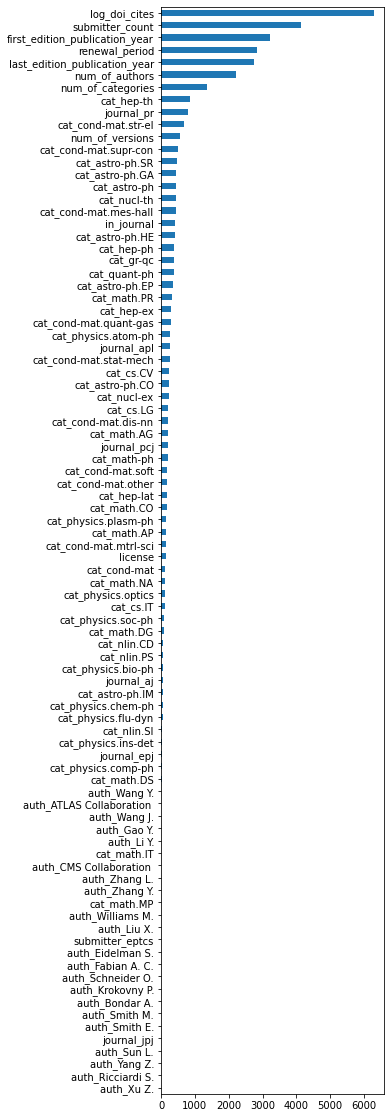

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(4, 20))
feature_importances.sort_values(ascending=True).plot.barh(ax=ax)

In [ ]:
result = result_df.mean(axis=1).apply(np.expm1).rename('cites')
result.head()

id
1605.00995           11.403798
1206.6911            32.204216
cond-mat/0504055    105.266554
astro-ph/9907297     10.061253
1104.5407             9.180536
Name: cites, dtype: float64

In [ ]:
result.to_csv(OUTPUT_FILE)
files.download(OUTPUT_FILE)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>